In [67]:
import os
import sys
from pathlib import Path  

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from PIL import Image  

import cv2 
from tqdm.notebook import tqdm 

In [68]:
tr_data_path = Path("../data/raw/train/images")

image_files = list(tr_data_path.glob("*"))
len(image_files)

150

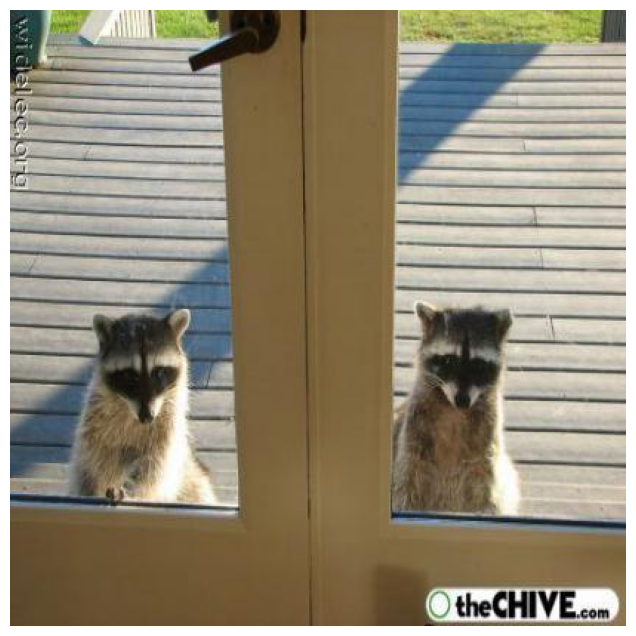

In [69]:
img_path = image_files[50]

img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

данные для каждого енота на картинке формата: класс x_center y_center width height

боксы для картинки выше:

 1:(26, 196), (144, 350)
416 416
 2:(257, 190), (356, 349)
416 416


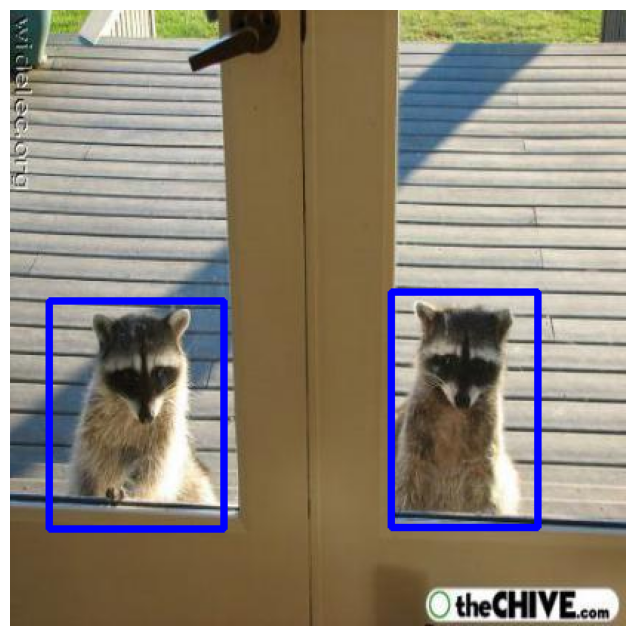

In [70]:
import cv2
import numpy as np

label_path = Path("../data/raw/train/labels") / f"{img_path.stem}.txt"

with open(label_path, 'r') as f:
    coords = f.read().strip().split('\n')


img_cv = cv2.imread(str(img_path))
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)  

h, w = img_cv.shape[:2]

for i, c in enumerate(coords):
    
    l = [float(a) for a in c.split()]
      
    #пиксели
    x1 = int((l[1] - l[3]/2) * w)
    y1 = int((l[2] - l[4]/2) * h)
    x2 = int((l[1] + l[3]/2) * w)
    y2 = int((l[2] + l[4]/2) * h)

    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
    print(f" {i + 1}:({x1}, {y1}), ({x2}, {y2})")
    print(h, w)

plt.imshow(img_cv)
plt.axis('off')
plt.show()

в папке export все картинки датасета

In [89]:
import pandas as pd

all_boxes_info = []
counts_per_image = []
without_labels = 0

images = Path("../data/raw/export/images").glob("*")
labels = Path("../data/raw/export/labels")

for img_path in images:
    label_path = labels/ f"{img_path.stem}.txt"
    
    if label_path.exists():
        with open(label_path, 'r') as f:
            coords = f.readlines()
            
            num_raccoons = len(coords)
            counts_per_image.append(num_raccoons)
        
        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]
        
        for c in coords:
            l = [float(a) for a in c.split()]
            
            box_w = l[3] * w
            box_h = l[4] * h
            
            all_boxes_info.append({
                'image': img_path.name,
                'width': box_w,
                'height': box_h,
                'area': box_w * box_h,
                'area_relative': l[3] * l[4], 
                'x_center': l[1],
                'y_center': l[2]
            })
    else:
        
        without_labels += 1
        counts_per_image.append(0)  


df = pd.DataFrame(all_boxes_info)


print(f"all boxes: {len(df)}")
print(f"mean size: {df['width'].mean():.0f}x{df['height'].mean():.0f}")
print(f"mean area: {df['area'].mean():.0f}")
print(f"% on picture: {df['area_relative'].mean()*100:.1f}%")
print(f"img without label: {without_labels}")

all boxes: 213
mean size: 254x318
mean area: 84521
% on picture: 48.8%
img without label: 0


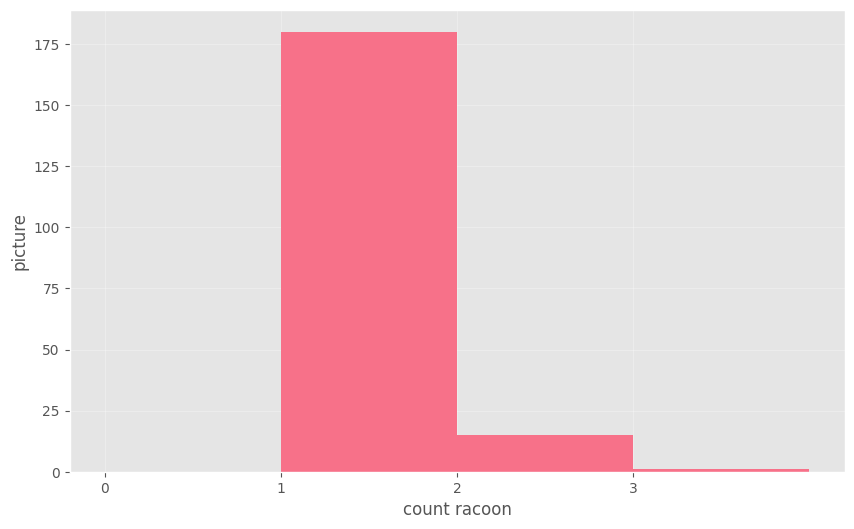

In [90]:
plt.figure(figsize=(10, 6))
if counts_per_image:  
    plt.hist(counts_per_image, bins=range(0, max(counts_per_image)+2) )
    plt.xlabel('count racoon')
    plt.ylabel('picture')
    plt.xticks(range(0, max(counts_per_image)+1))
    plt.grid(True, alpha=0.3)
    plt.show()


нахождение объектов на картинке:

X: 0.485
Y: 0.508


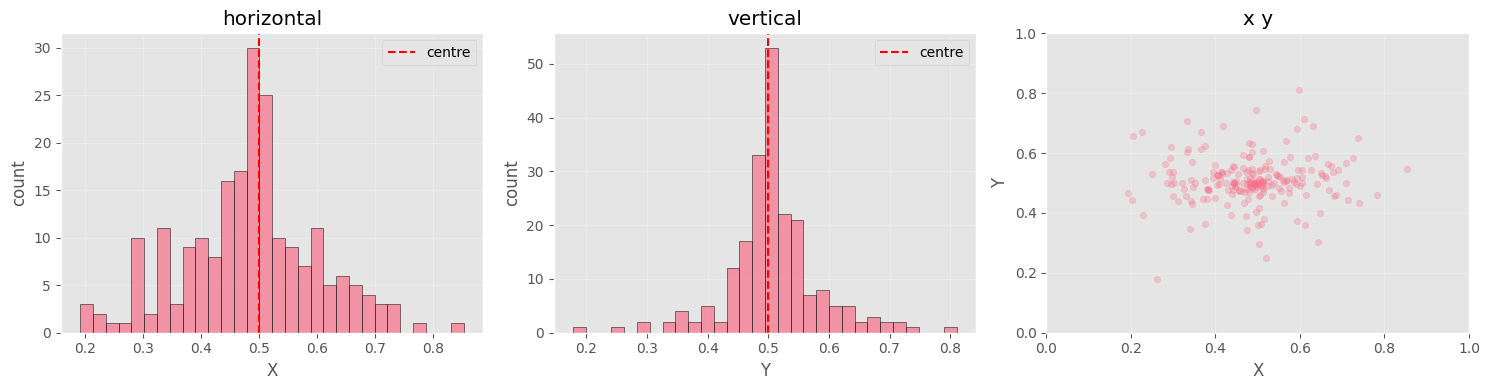

In [106]:

print(f"X: {df['x_center'].mean():.3f}")
print(f"Y: {df['y_center'].mean():.3f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Распределение по X
axes[0].hist(df['x_center'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.5, color='red', linestyle='--', label='centre')
axes[0].set_xlabel('X')
axes[0].set_ylabel('count')
axes[0].set_title('horizontal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Распределение по Y
axes[1].hist(df['y_center'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0.5, color='red', linestyle='--', label='centre')
axes[1].set_xlabel('Y')
axes[1].set_ylabel('count')
axes[1].set_title('vertical')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Scatter plot всех позиций
axes[2].scatter(df['x_center'], df['y_center'], alpha=0.3, s=20)
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[2].set_title('x y')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 0.5,0.5-идеальный центр
x_mean = df['x_center'].mean()
y_mean = df['y_center'].mean()



распределение равномерное

bounding boxes размеры:

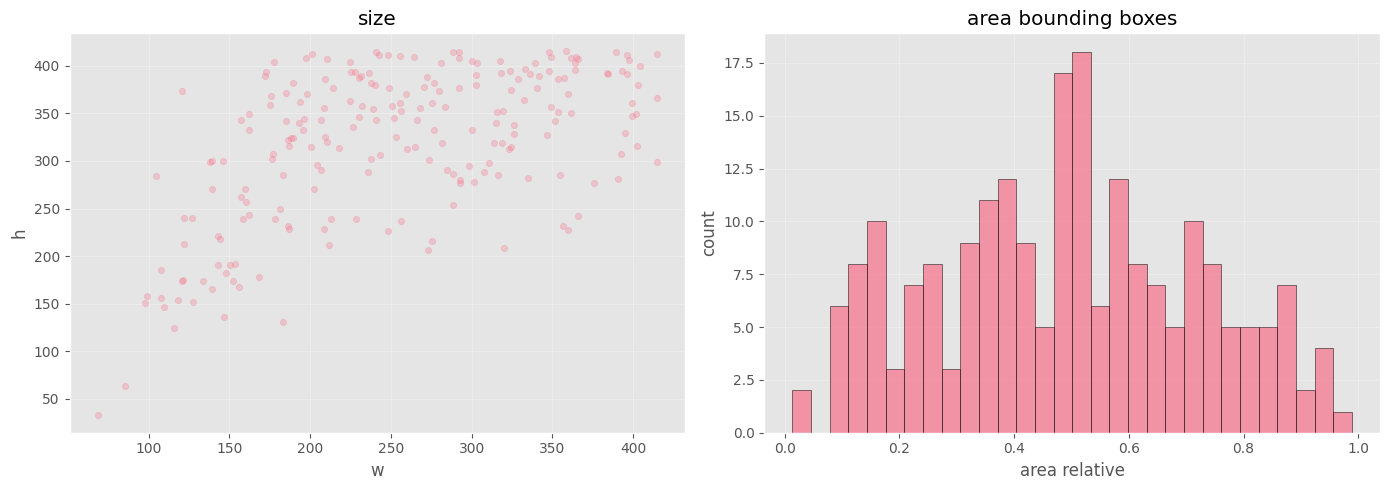

 small: 0 (0.0%)
 medium: 7 (3.3%)
 mean 98x119
  large 206 (96.7%)
  mean 259x325 


In [100]:

if len(df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].scatter(df['width'], df['height'], alpha=0.3, s=20)
    axes[0].set_xlabel('w')
    axes[0].set_ylabel('h')
    axes[0].set_title('size')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(df['area_relative'], bins=30, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('area relative')
    axes[1].set_ylabel('count')
    axes[1].set_title('area bounding boxes')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    small = df[df['area_relative'] < 0.01]    # < 1% 
    medium = df[(df['area_relative'] >= 0.01) & (df['area_relative'] < 0.1)]  # 1-10%
    large = df[df['area_relative'] >= 0.1]    # > 10%
    

    print(f" small: {len(small)} ({len(small)/len(df)*100:.1f}%)")
    if len(small) > 0:
        print(f"  {small['width'].mean():.0f}x{small['height'].mean():.0f} пикс")
    

    print(f" medium: {len(medium)} ({len(medium)/len(df)*100:.1f}%)")
    if len(medium) > 0:
        print(f" mean {medium['width'].mean():.0f}x{medium['height'].mean():.0f}")
    
    print(f"  large {len(large)} ({len(large)/len(df)*100:.1f}%)")
    if len(large) > 0:
        print(f"  mean {large['width'].mean():.0f}x{large['height'].mean():.0f} ")


почти все еноты большие; из минусов модель может переобучиться на больших енотах, также на маленьких енотах сеть скорее всего будет плохо работать


yaml для модели

In [108]:
import yaml
from pathlib import Path


base_path = Path("../data/raw")

config = {

    'path': '../data/raw',  
    
    'train': 'train/images',
    'val': 'valid/images', 
    'test': 'test/images',
    
    'nc': 1,  # 1 класс 
    'names': ['raccoon'],
}


yaml_path = Path('../data/raccoon_dataset.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

